# Assignment 4: Text Classification

    Author: Group F - Gaurav, Xiaowen Sun, Jheel Harnish Kamdar, Ruijia Xiong
    Created at: 04/09/2024

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from datasets import load_dataset
from wordcloud import WordCloud
from tqdm import tqdm
import torch
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline, BartTokenizer, BartForConditionalGeneration
from transformers import MT5ForConditionalGeneration, MT5Tokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 9

## 1. Data Exploration

In [ ]:
train_dataset = load_dataset('yelp_review_full', split='train')
test_dataset = load_dataset('yelp_review_full', split='test')
print(train_dataset)
print(test_dataset)
print('Train dataset label values', Counter(train_dataset['label']))
print('Test dataset label values', Counter(test_dataset['label']))

Dataset({
    features: ['label', 'text'],
    num_rows: 650000
})
Dataset({
    features: ['label', 'text'],
    num_rows: 50000
})
Train dataset label values Counter({4: 130000, 1: 130000, 3: 130000, 0: 130000, 2: 130000})
Test dataset label values Counter({0: 10000, 2: 10000, 1: 10000, 3: 10000, 4: 10000})




*   The yelp_review dataset has the train datset and the test dataset. Both datasets have two columns: text and label. Both datasets are well-labeled.
*    The train dataset has 650,000 rows of data, and the test dataset has 50,000 entities. Both dataset is balanced - each of the 5 classes has same amount of entites.
*   **For Our Assignment 4, we'll be using 10,000 rows of data from the test dataset.**






In [ ]:
# dataset = load_dataset('yelp_review_full', split='test[:20%]')
dataset = load_dataset('yelp_review_full', split='test').shuffle(seed=seed).select(range(10000))
df = dataset.to_pandas()
print(f'test data frame shape: {df.shape}')

test data frame shape: (10000, 2)


label
0    2048
2    2017
1    1995
3    1982
4    1958
Name: count, dtype: int64


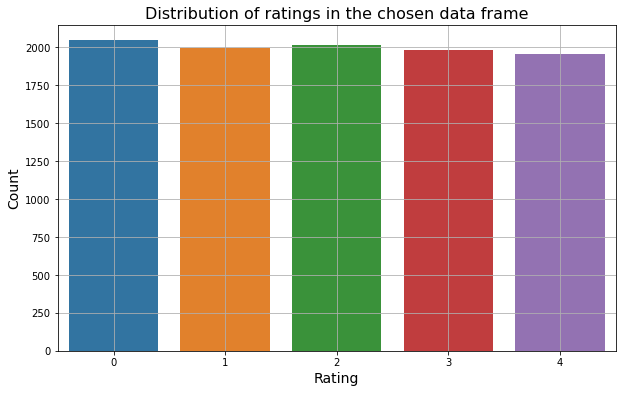

In [ ]:
print(df.label.value_counts())

# Visualize the distribution of review ratings
plt.figure(figsize=(10, 6))  # Increasing the figure size for better readability
sns.countplot(x='label', data=df)
plt.title('Distribution of ratings in the chosen data frame', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)  # Add grid for better readability of the plot
plt.show()



*   We chose 10,000 reviews to process, each class has almost 2,000 reviews




(array([5.078e+03, 2.932e+03, 1.154e+03, 4.530e+02, 1.990e+02, 7.600e+01,
        5.300e+01, 3.300e+01, 1.800e+01, 4.000e+00]),
 array([1.000e+00, 1.018e+02, 2.026e+02, 3.034e+02, 4.042e+02, 5.050e+02,
        6.058e+02, 7.066e+02, 8.074e+02, 9.082e+02, 1.009e+03]),
 <BarContainer object of 10 artists>)

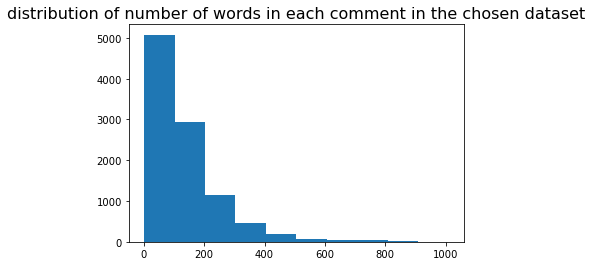

In [ ]:
lens=[len(i.split()) for i in df.text]
plt.title('distribution of number of words in each comment in the chosen dataset', fontsize=16)
plt.hist(lens)

* We'll trim the length of the reviews according to the max_length each model can take. Now we can see a max_length of 500 is going to work well for our dataset

## 2. Sentiment Analysis
* Since most sentiment analysis transformers give binary labels, we're converting our dataset labels to binary.

In [ ]:
# Convert the reviews to binary label for sentiment analysis
df['binary label'] = np.where(df['label'] < 2, 0, 1)

* For the sentiment analysis task, we are choosing four fine tuned models, each model predict a binary outcome
  * Bert: textattack/bert-base-uncased-SST-2
  * Bert2: textattack/bert-base-uncased-yelp-polarity
      * (This bert-base-uncased model was fine-tuned for sequence classification using TextAttack and the yelp_polarity dataset loaded using the nlp library. The model was fine-tuned for 5 epochs with a batch size of 16, a learning rate of 5e-05, and a maximum sequence length of 256. Since this was a classification task, the model was trained with a cross-entropy loss function. The best score the model achieved on this task was 0.9699473684210527, as measured by the eval set accuracy, found after 4 epochs.)
  * RoBERTa: textattack/roberta-base-SST-2
  * DistilBERT: distilbert-base-uncased-finetuned-sst-2-english
      * This model is a fine-tune checkpoint of DistilBERT-base-uncased, fine-tuned on SST-2. This model reaches an accuracy of 91.3 on the dev set (for comparison, Bert bert-base-uncased version reaches an accuracy of 92.7).

### 2.1 Sentiment Analysis Pipelines

In [ ]:
pipelines = {
    'BERT': pipeline('sentiment-analysis', model='textattack/bert-base-uncased-SST-2', truncation=True, padding=True, device=device),
    'BERT2': pipeline('sentiment-analysis', model='textattack/bert-base-uncased-yelp-polarity', truncation=True, padding=True, device=device),
    'tuned_BERT': pipeline('sentiment-analysis', model='LiYuan/amazon-review-sentiment-analysis', tokenizer='LiYuan/amazon-review-sentiment-analysis', truncation=True, padding=True, device=device),
    'RoBERTa': pipeline('sentiment-analysis', model='textattack/roberta-base-SST-2', truncation=True, padding=True, device=device),
    'DistilBERT': pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english', truncation=True, padding=True, device=device)
}

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
%%time
def sentiment_analysis(example):
    bert = pipelines['BERT'](example['text'])[0]['label']
    bert2 = pipelines['BERT2'](example['text'])[0]['label']
    roberta = pipelines['RoBERTa'](example['text'])[0]['label']
    distilbert = pipelines['DistilBERT'](example['text'])[0]['label']
    return {'text': example['text'],
            'BERT': bert,
            'BERT2': bert2,
            'RoBERTa': roberta,
            'DistilBERT': distilbert}
dataset_labels = dataset.map(sentiment_analysis)

CPU times: user 7.25 s, sys: 2.13 s, total: 9.38 s
Wall time: 9.38 s


* Convert labels to intergers: 0-Negative, 1-Positive  

### 2.2 Prediction Distribution for each model

In [ ]:
for col in ['BERT', 'BERT2', 'RoBERTa', 'DistilBERT']:
    df[col] = dataset_labels[col]
df['BERT'] = df['BERT'].apply(lambda x: int(x[-1]))
df['BERT2'] = df['BERT2'].apply(lambda x: int(x[-1]))
df['RoBERTa'] = df['RoBERTa'].apply(lambda x: int(x[-1]))
df['DistilBERT'] = np.where(df['DistilBERT'] == 'NEGATIVE', 0, 1)

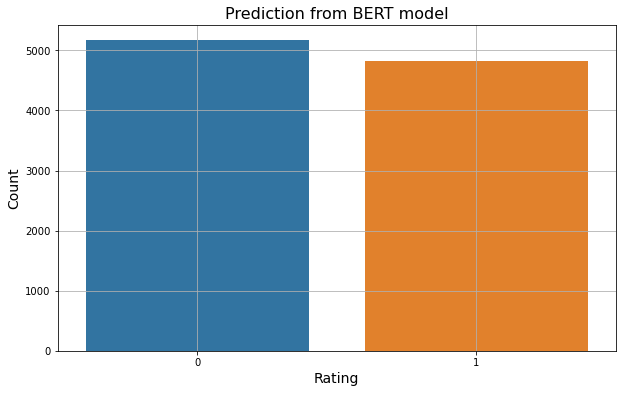

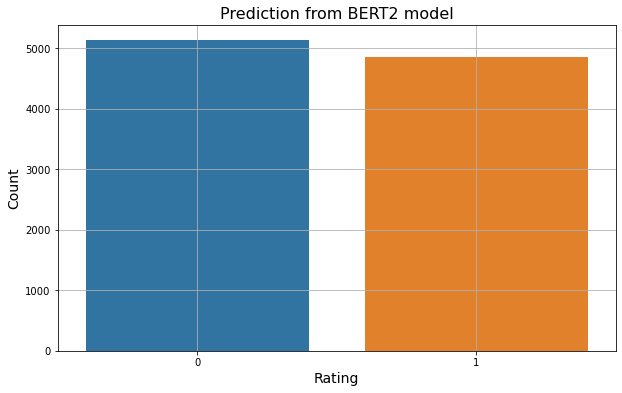

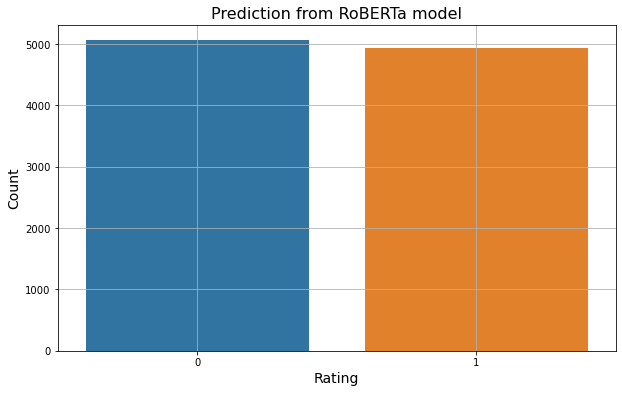

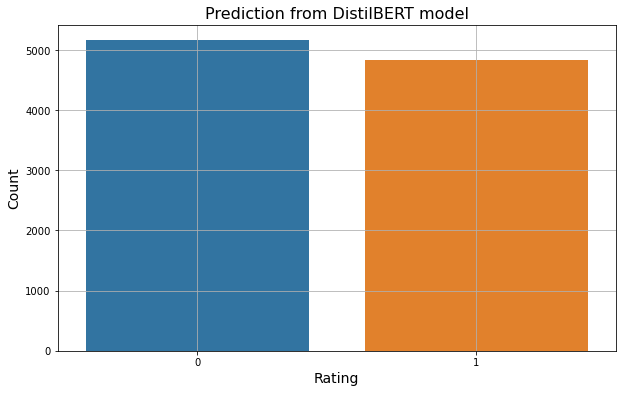

In [ ]:
for col in ['BERT', 'BERT2', 'RoBERTa', 'DistilBERT']:
  plt.figure(figsize=(10, 6))
  sns.countplot(x=col, data=df)
  plt.title(f'Prediction from {col} model', fontsize=16)
  plt.xlabel('Rating', fontsize=14)
  plt.ylabel('Count', fontsize=14)
  plt.grid(True)
  plt.show()

### 2.3 Evaluation of model Performance

********************************BERT model********************************
Accuracy: 0.8343
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      4043
           1       0.95      0.77      0.85      5957

    accuracy                           0.83     10000
   macro avg       0.84      0.85      0.83     10000
weighted avg       0.86      0.83      0.84     10000



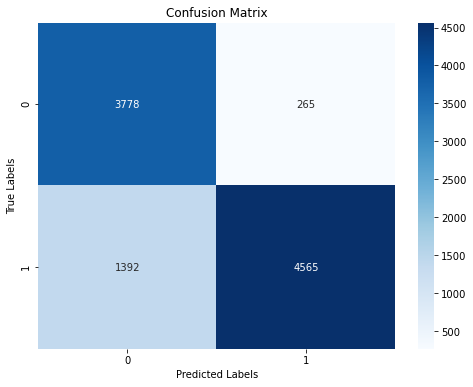

********************************BERT2 model********************************
Accuracy: 0.8886
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4043
           1       1.00      0.81      0.90      5957

    accuracy                           0.89     10000
   macro avg       0.89      0.91      0.89     10000
weighted avg       0.91      0.89      0.89     10000



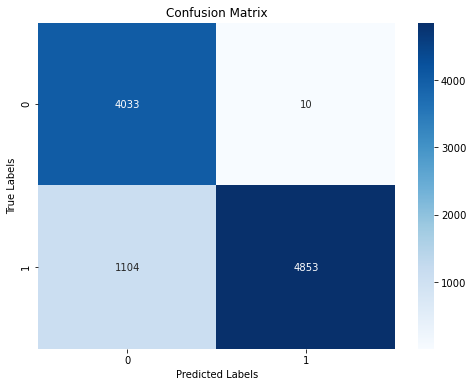

********************************RoBERTa model********************************
Accuracy: 0.8613
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      4043
           1       0.96      0.80      0.87      5957

    accuracy                           0.86     10000
   macro avg       0.86      0.88      0.86     10000
weighted avg       0.88      0.86      0.86     10000



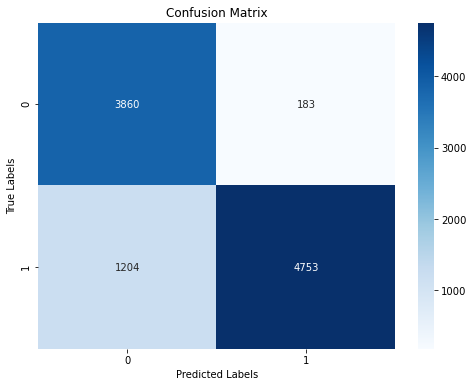

********************************DistilBERT model********************************
Accuracy: 0.8181
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.91      0.80      4043
           1       0.93      0.75      0.83      5957

    accuracy                           0.82     10000
   macro avg       0.82      0.83      0.82     10000
weighted avg       0.84      0.82      0.82     10000



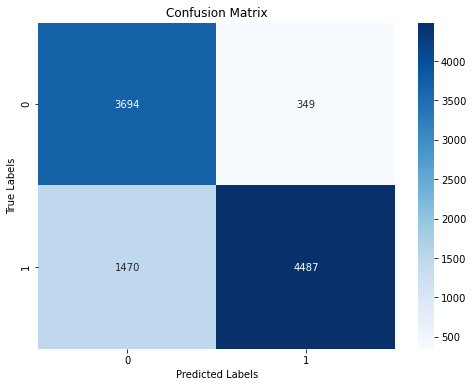

In [ ]:
def evaluate(labels, predictions, xticklabels=[0,1], yticklabels=[0,1]):
    # Accuracy
    accuracy = accuracy_score(labels, predictions)
    print("Accuracy:", accuracy)

    # Classification Report
    class_report = classification_report(labels, predictions)
    print("Classification Report:")
    print(class_report)

    # Confusion Matrix
    conf_matrix = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=xticklabels, yticklabels=yticklabels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
for col in ['BERT', 'BERT2', 'RoBERTa', 'DistilBERT']:
    labels = df['binary label']
    predictions = df[col]
    print(f'********************************{col} model********************************')
    evaluate(labels, predictions)

### 2.4 Visualizing Misclassifications Using Word Clouds

******************************BERT Misclassification******************************


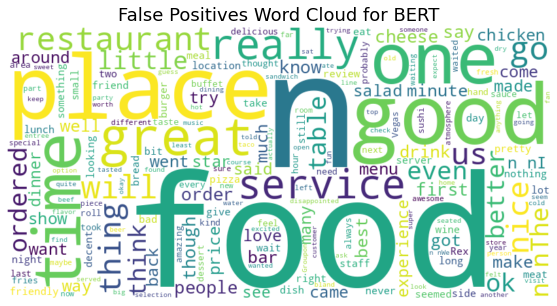

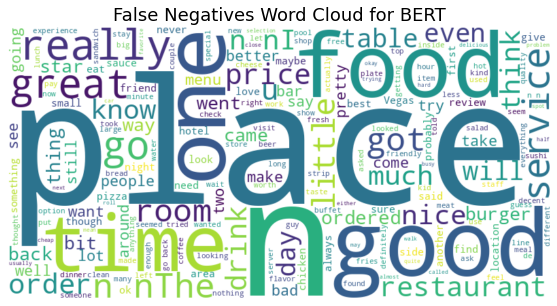

******************************BERT2 Misclassification******************************


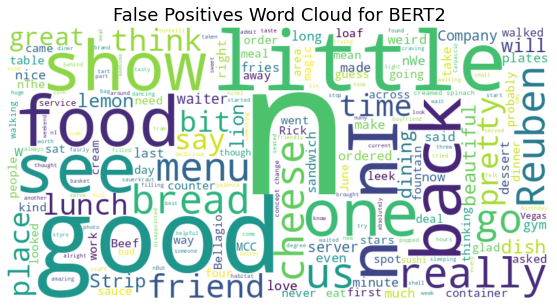

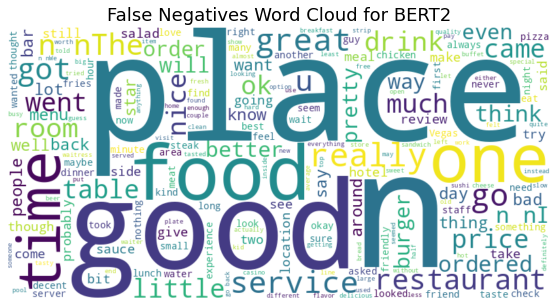

******************************RoBERTa Misclassification******************************


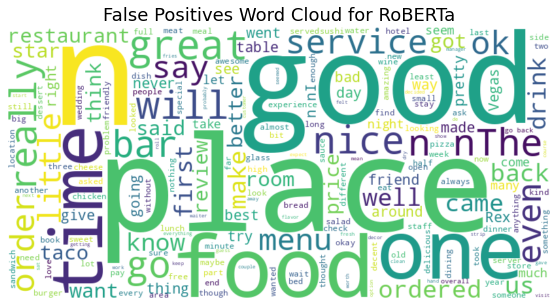

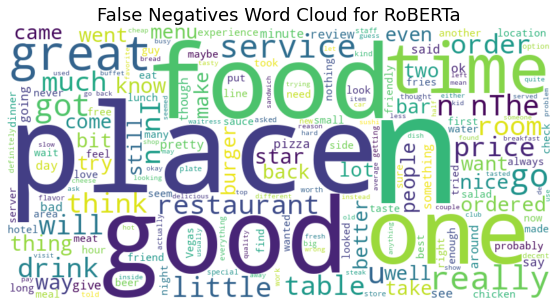

******************************DistilBERT Misclassification******************************


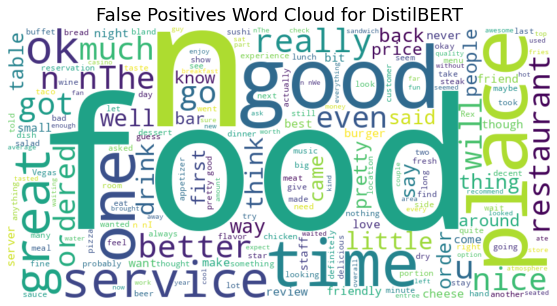

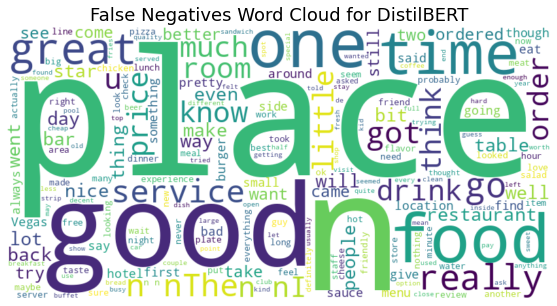

In [ ]:
def plot_word_cloud(texts, title):
    if not texts:
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(texts))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()

for model_name in ['BERT', 'BERT2', 'RoBERTa', 'DistilBERT']:
    print(f'******************************{model_name} Misclassification******************************')
    false_positives_texts = df[(df['binary label'] == 0) & (df[model_name] == 1)]['text'].tolist()
    false_negatives_texts = df[(df['binary label'] == 1) & (df[model_name] == 0)]['text'].tolist()

    # Plot word clouds for false positives and false negatives
    plot_word_cloud(false_positives_texts, f'False Positives Word Cloud for {model_name}')
    plot_word_cloud(false_negatives_texts, f'False Negatives Word Cloud for {model_name}')

### 2.5 Analyze model performance by sentiment intensity

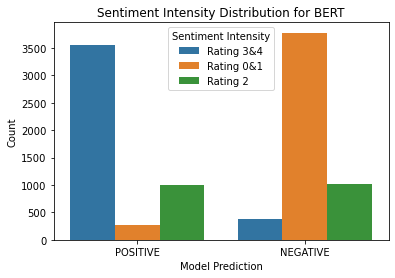

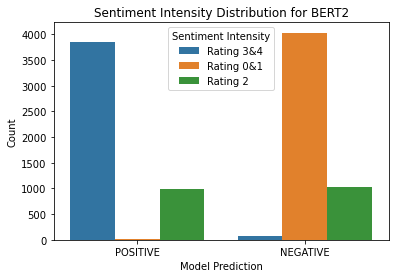

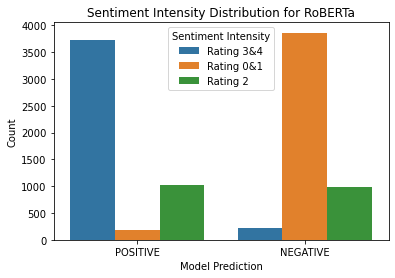

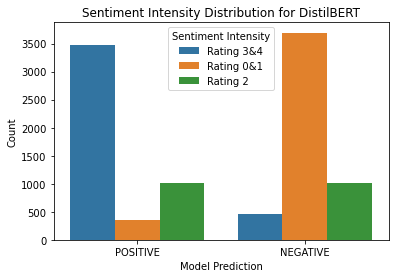

In [ ]:
def sentiment_intensity_analysis():
    # Creating a new column for sentiment intensity based on original ratings
    df['intensity'] = df['label'].apply(lambda x: 'Rating 0&1' if x < 2 else 'Rating 2' if x == 2 else 'Rating 3&4')

    # Plotting model performance by sentiment intensity
    for model_name in ['BERT', 'BERT2', 'RoBERTa', 'DistilBERT']:
        sns.countplot(x=df[model_name].apply(lambda x: 'NEGATIVE' if x==0 else 'POSITIVE'), hue=df['intensity'])
        plt.title(f'Sentiment Intensity Distribution for {model_name}')
        plt.xlabel('Model Prediction')
        plt.ylabel('Count')
        plt.legend(title='Sentiment Intensity')
        plt.show()

sentiment_intensity_analysis()

* If we look at the misclassified Rating0&1, and misclassified Rating 3&4 in the above plots:
  * We can see that BERT2 has the least misclassification, then RoBERTa. DistilBERT has the most misclassification among the four modes.

### 2.6 Compare model performance

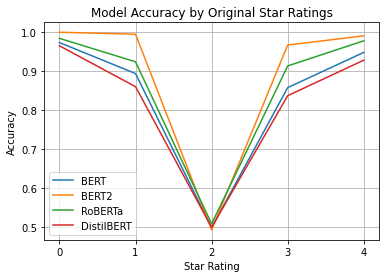

In [ ]:
# Comparative accuracy across models by original star ratings
def comparative_accuracy_by_rating():
    ratings = sorted(df['label'].unique())
    accuracies = {model: [] for model in ['BERT', 'BERT2', 'RoBERTa', 'DistilBERT']}

    for rating in ratings:
        subset = df[df['label'] == rating]
        for model in ['BERT', 'BERT2', 'RoBERTa', 'DistilBERT']:
            acc = accuracy_score(subset['binary label'], subset[model])
            accuracies[model].append(acc)

    # Plotting
    for model, acc_list in accuracies.items():
        plt.plot(ratings, acc_list, label=model)

    plt.title('Model Accuracy by Original Star Ratings')
    plt.xlabel('Star Rating')
    plt.ylabel('Accuracy')
    plt.xticks(ratings)
    plt.legend()
    plt.grid(True)
    plt.show()

comparative_accuracy_by_rating()

* From the above, we can see that Rating 2 gets the lowest accuracy for all the models. That's because Rating 2 is pretty neutral and the misclassification is more likely to happen compared to the more POSITIVE or more NEGATIVE ratings.

### 2.7 False Prediction text/review analysis

In [ ]:
# False Positive Examples
count = 0
for _, row in df.iterrows():
    if row['label'] == 1:
        flag = 0
        for col in ['BERT', 'BERT2', 'RoBERTa', 'DistilBERT']:
            if row[col] == 1:
                flag = 1
        if flag:
            count += 1
            print('===============================================================')
            print(len(row['text'].split()))
            print("Original Text:", row['text'])
            print('\n')
            print("Original Label:", row['label'])
            print(f"bert: {row['BERT']}")
            print(f"bert2: {row['BERT2']}")
            print(f"roberta: {row['RoBERTa']}")
            print(f"distilbert: {row['DistilBERT']}")
            if count == 50:
                break

57
Original Text: Hopefully they like your song choices or else you will buy drinks while waiting to get your name called.. The table next to us got here after us and submitted their song choices after us and got to perform before us.  Geisha Go Go is better and you'll spend the same amount and actually get to sing!


Original Label: 1
bert: 1
bert2: 0
roberta: 0
distilbert: 1
27
Original Text: this place had terrible service the morning that i went and it's not worth it for the price we paid.  it was just ok....i wouldn't go back


Original Label: 1
bert: 0
bert2: 0
roberta: 0
distilbert: 1
129
Original Text: Decent food at an affordable price. We came to eat here around 1am on a Friday night when we first arrived in Vegas. It was pretty busy but we were seated right away. I shared the 7 oz. steak with hash browns, eggs, and toast with my boyfriend because I wasn't too hungry. The steak was OK at best - it was well done on one half and medium on the other, we asked for medium- but who

In [ ]:
# False Negative Examples
count = 0
for _, row in df.iterrows():
    if (row['label'] == 2 or row['label'] == 3):
        flag = 0
        for col in ['BERT', 'BERT2', 'RoBERTa', 'DistilBERT']:
            if row[col] == 0:
                flag = 1
        if flag:
            count += 1
            print('===============================================================')
            print(len(row['text'].split()))
            print("Original Text:", row['text'])
            print('\n')
            print("Original Label:", row['label'])
            print(f"bert: {row['BERT']}")
            print(f"bert2: {row['BERT2']}")
            print(f"roberta: {row['RoBERTa']}")
            print(f"distilbert: {row['DistilBERT']}")
            if count == 50:
                break

63
Original Text: Inside Circus Circus, the hotel has a lot of happy hour special prices. $2 for chips and salsa, $2 shrimp cocktail, $2 margaritas, $2 bloody marys. An okay atmosphere and option if you want to eat inside this hotel, however I would not go out of my way to eat here. More or less a works if you're in the area and hungry.


Original Label: 2
bert: 1
bert2: 0
roberta: 0
distilbert: 1
76
Original Text: I came here often. \n\nGirls: Mostly gorgeous\n\nDrinks: South Scottsdale prices at a club...y'get my drift.\n\nParking: Sucks. Park at dark lot or pay valet otherwise, get here at buttcrack dusk. \n\nThis place is pretty close to a Vegas style strip club. I like it, there's no bs here associated with the Phoenix clubs. I just get paranoid parking in the dark lot. \n\nNever had a bad time here. Then again, never had a great time here either.


Original Label: 3
bert: 0
bert2: 1
roberta: 0
distilbert: 0
352
Original Text: So I finally got around to checking out Crystals and I

* From the above False Positive examples:
  * Ok at best
  * OK place if you're drunk or don't feel like going out to the strip but definitely not a destination eatery
  * Felt it was just alright, nothing terrible but I wouldn't want to order it again
When you say it's ok and give only 1 star, it's easy for most models to think the text is POSITIVE


* From the above False Negative examples:
  * Good food terrible parking: Never had a bad time here. Then again, never had a great time here either.
  * Dammmm it, I have to go back again! - **Only BERT2 get it right**
  * The food was great, but the service was disappointing. - **Only BERT2 get it right**
BERT2 was fine tuned on restaurant reviews too so it's much better than other models to predict on the yelp review

## 3. Classification Tasks


### 3.a Classification Based on Summaries

#### 3.a.1 Text Summarize

* We use facebook bart transformer to summarize the review text. It's BART model pre-trained on English language, and fine-tuned on CNN Daily Mail.
* BART is a transformer encoder-encoder (seq2seq) model with a bidirectional (BERT-like) encoder and an autoregressive (GPT-like) decoder. BART is pre-trained by (1) corrupting text with an arbitrary noising function, and (2) learning a model to reconstruct the original text.

* BART is particularly effective when fine-tuned for text generation (e.g. summarization, translation) but also works well for comprehension tasks (e.g. text classification, question answering). This particular checkpoint has been fine-tuned on CNN Daily Mail, a large collection of text-summary pairs.

In [ ]:
# Initialize the BART tokenizer and model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
model.to(device)

# Function to generate summaries
def generate_summary(text):
    inputs = tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)
    inputs = inputs.to(device)
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, min_length=30, max_length=150, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Generate summaries for each review in the dataset
summaries = []
for example in tqdm(dataset):
    review = example['text']
    summary = generate_summary(review)
    summaries.append(summary)

100%|██████████| 10000/10000 [1:23:27<00:00,  2.00it/s]


In [ ]:
df['summary'] = summaries

#### 3.a.2 Sentiment Analysis for Summaries

In [ ]:
%%time
models = {
    'sum_BERT':"textattack/bert-base-uncased-SST-2",
    'sum_BERT2':"textattack/bert-base-uncased-yelp-polarity",
    'sum_RoBERTa':"textattack/roberta-base-SST-2",
    'sum_DistilBERT':"distilbert-base-uncased-finetuned-sst-2-english"
}
predictions = {}

max_seq_length = 512

# Iterate over each model
for name, model in models.items():
    # Load the sentiment analysis pipeline
    sentiment_pipeline = pipeline(task='sentiment-analysis', model=model, device=device)

    # Preprocess text to ensure it fits within the maximum sequence length
    preprocessed_texts = []
    for text in df['text']:
        # Truncate or split longer sequences
        if len(text) > max_seq_length:
            # Truncate the text
            text = text[:max_seq_length]
        preprocessed_texts.append(text)

    # Get the model's predictions on the preprocessed text data
    _ = sentiment_pipeline(preprocessed_texts)
    pred = [element['label'] for element in _]
    # Store the predictions
    predictions[name] = pred

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 3min 57s, sys: 2.71 s, total: 4min
Wall time: 3min 56s


In [ ]:
for col in predictions:
    df[col] = predictions[col]

In [ ]:
df['sum_BERT'] = df['sum_BERT'].apply(lambda x: int(x[-1]))
df['sum_BERT2'] = df['sum_BERT2'].apply(lambda x: int(x[-1]))
df['sum_RoBERTa'] = df['sum_RoBERTa'].apply(lambda x: int(x[-1]))
df['sum_DistilBERT'] = np.where(df['sum_DistilBERT'] == 'NEGATIVE', 0, 1)

#### 3.a.3 Evaluate Binary Sentiment Analysis models

********************************sum_BERT model********************************
Accuracy: 0.8094
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79      4043
           1       0.91      0.75      0.82      5957

    accuracy                           0.81     10000
   macro avg       0.81      0.82      0.81     10000
weighted avg       0.83      0.81      0.81     10000



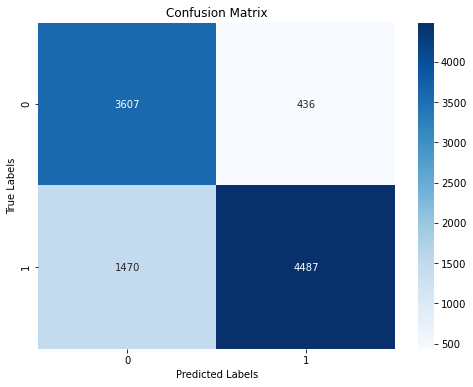

********************************sum_BERT2 model********************************
Accuracy: 0.8767
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      4043
           1       0.98      0.81      0.89      5957

    accuracy                           0.88     10000
   macro avg       0.88      0.89      0.88     10000
weighted avg       0.90      0.88      0.88     10000



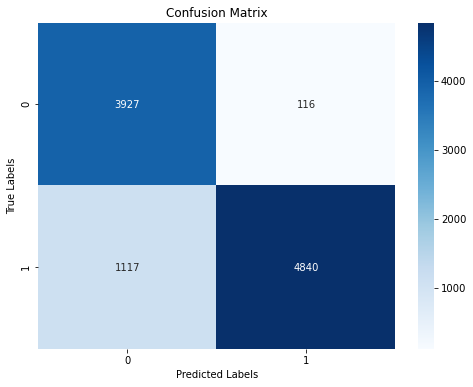

********************************sum_RoBERTa model********************************
Accuracy: 0.8374
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82      4043
           1       0.93      0.79      0.85      5957

    accuracy                           0.84     10000
   macro avg       0.84      0.85      0.84     10000
weighted avg       0.85      0.84      0.84     10000



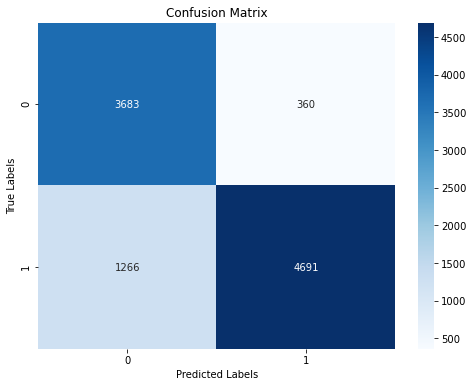

********************************sum_DistilBERT model********************************
Accuracy: 0.7955
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.87      0.77      4043
           1       0.89      0.75      0.81      5957

    accuracy                           0.80     10000
   macro avg       0.80      0.81      0.79     10000
weighted avg       0.81      0.80      0.80     10000



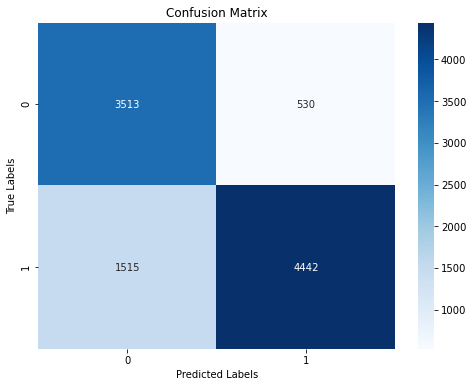

In [ ]:
for col in ['sum_BERT', 'sum_BERT2', 'sum_RoBERTa', 'sum_DistilBERT']:
    labels = df['binary label']
    predictions = df[col]
    print(f'********************************{col} model********************************')
    evaluate(labels, predictions)

####3.a.4 Evaluate Multiclass Sentiment Analysis models

In [ ]:
tuned_BERT = pipeline('sentiment-analysis', model='LiYuan/amazon-review-sentiment-analysis', tokenizer='LiYuan/amazon-review-sentiment-analysis', truncation=True, padding=True, device=device)

# Preprocess text to ensure it fits within the maximum sequence length
preprocessed_texts = []
for text in df['summary']:
    # Truncate or split longer sequences
    if len(text) > max_seq_length:
        # Truncate the text
        text = text[:max_seq_length]
    preprocessed_texts.append(text)

# Get the model's predictions on the preprocessed text data
_ = tuned_BERT(preprocessed_texts)

In [ ]:
df['sum_tuned_BERT'] = [element['label'] for element in _]
df['sum_tuned_BERT'] = df['sum_tuned_BERT'].apply(lambda x: int(x[0])-1)
df['sum_tuned_BERT'].value_counts()

sum_tuned_BERT
4    4643
0    2116
2    1333
3    1100
1     808
Name: count, dtype: int64

Accuracy: 0.451
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.67      0.65      2048
           1       0.54      0.22      0.31      1995
           2       0.42      0.28      0.33      2017
           3       0.30      0.17      0.21      1982
           4       0.39      0.93      0.55      1958

    accuracy                           0.45     10000
   macro avg       0.46      0.45      0.41     10000
weighted avg       0.46      0.45      0.41     10000



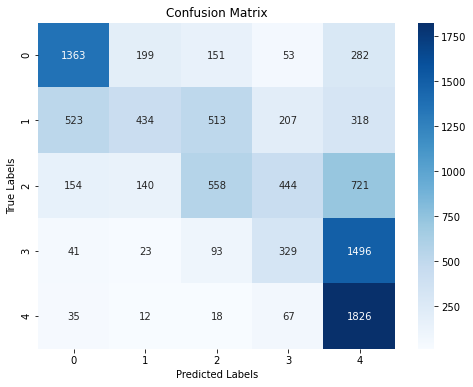

In [ ]:
evaluate(df.label, df['sum_tuned_BERT'], xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])

* The sentiment analysis prediction on all 5 classes. The accuracy for the whole dataset is much lower than that of binary classification.
* Of the five classes:
  * Rating 0 has the highest accuracy
  * Rating 4 has the second highest accuracy and the highest recall. We can see if the review's very positive, it's very likely to be predict to the right class. The low recall of Rating 4 might be that Rating 3 can be easily mixed up with Rating 4
  * Rating 3 turned out to have the lowest accuracy and recall. It might be because Rating 3 is easily mixed up with Rating 4 or Rating 2

### 3.b Zero-Shot Classification

In [ ]:
candidate_tags = ["Restaurants", "Bars", "Coffee Shops", "Hotels", "Salons/Barbershops", "Auto Repair", "Home Services", "Medical Services", "Entertainment", "Pet Services", "Financial Services", "Travel & Tourism", "Education", "Real Estate", "Fitness", "Landscaping & Gardening Services", "Legal Services", "Photography Services", "Childcare Services", "Computer & Technology Services"]

#### 3.b.1 Choose 100 reviews

In [ ]:
dataset_100 = load_dataset('yelp_review_full', split='test').shuffle(seed=seed).select(range(100))

#### 3.b.2 Zero-shot Classification by Three different models
* Models used for zero-shot classification are models that are fined-tuned for zero-shot classification tasks, the three models are:
  * BART: facebook/bart-large-mnli
    * This is the checkpoint for bart-large after being trained on the MultiNLI (MNLI) dataset.
  * DeBERTa: MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli
    * This model was trained on the MultiNLI, Fever-NLI and Adversarial-NLI (ANLI) datasets, which comprise 763 913 NLI hypothesis-premise pairs. This base model outperforms almost all large models on the ANLI benchmark. The base model is DeBERTa-v3-base from Microsoft. The v3 variant of DeBERTa substantially outperforms previous versions of the model by including a different pre-training objective, see annex 11 of the original DeBERTa paper.
  * CrossEncoder: cross-encoder/nli-MiniLM2-L6-H768
    * This model was trained using SentenceTransformers Cross-Encoder class. The model was trained on the SNLI and MultiNLI datasets.

* **All three zero-shot classification models are fine tuned on the MNLI dataset**

In [ ]:
%%time
zero_pipelines = {
    'BART':pipeline(task="zero-shot-classification", model = "facebook/bart-large-mnli", device=device),
    'DeBERTa':pipeline(task="zero-shot-classification", model = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", tokenizer = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", device=device),
    # sentence transformer: cross encoder
    'CrossEncoder': pipeline(task="zero-shot-classification", model = "cross-encoder/nli-MiniLM2-L6-H768", tokenizer = "cross-encoder/nli-MiniLM2-L6-H768", device=device)}

def zero_shot_classification(example, candidate_tags, pipeline):
    zeroshot = pipeline(example['text'], candidate_tags)
    return {'text': example['text'], 'zeroshot': zeroshot}

outcome = defaultdict(list)
for name in zero_pipelines:
    _ = dataset_100.map(lambda example: zero_shot_classification(example, candidate_tags, zero_pipelines[name]))
    for element in _['zeroshot']:
        outcome[name].append(element['labels'][0])

In [ ]:
for i, text in enumerate(dataset_100['text']):
  print(f'Review {i+1}: {text}')

Review 1: Wow! This place has some of the best steak i have ever ate (and i am a steak and potato person). A little pricey but well worth every cent. Did have an issue with the hostess when i called to see about their wait, she said there was none and when i got there it happen to be 30 mins (took like 20 mins to get seated) and it took me 3-5 mins to get there. If there was a wait, she should of just told us and i would of been okay with it. \n\nStepped into the bar area and they had some live music playing, a guy on the piano. The bartender was nice and they had a decent selection of beers. We finally got seated and it did take a minute for the waiter to attend to us but it is ok. I ordered a wedge salad to start with a rib eye steak as my main course. I ordered the asparagus and my coworker also ordered the rib eye with potatoes au gratin (caesar salad as a starter). Sides are family style. Started with the bread which was wonderful, the salads where good but nothing spectacular. Th

#### 3.b.3 Manually classify the chosen reviews

In [ ]:
manual_classification_result = [
    "Restaurants", "Restaurants", "Retail", "Computer & Technology Services", "Restaurants",
    "Hotels", "Legal Services", "Restaurants", "Hotels", "Home Services",
    "Restaurants", "Coffee Shops", "Restaurants", "Restaurants", "Restaurants",
    "Salons/Barbershops", "Retail", "Restaurants", "Hotels", "Auto Repair",
    "Restaurants", "Hotels", "Restaurants", "Hotels", "Restaurants",
    "Entertainment", "Medical Services", "Travel & Tourism", "Hotels", "Hotels",
    "Restaurants", "Hotels", "Coffee Shops", "Bars", "Restaurants",
    "Restaurants", "Restaurants", "Restaurants", "Restaurants", "Entertainment",
    "Restaurants", "Entertainment", "Pet Services", "Restaurants", "Retail",
    "Pet Services", "Restaurants", "Entertainment", "Dry Cleaning & Laundry", "Restaurants",
    "Hotels", "Restaurants", "Entertainment", "Restaurants", "Hotels",
    "Coffee Shops", "Restaurants", "Hotels", "Restaurants", "Hotels",
    "Hotels", "Legal Services", "Restaurants", "Coffee Shops", "Restaurants",
    "Bars", "Restaurants", "Computer & Technology Services", "Medical Services", "Shoe Repair",
    "Restaurants", "Entertainment", "Auto Repair", "Restaurants", "Restaurants",
    "Restaurants", "Fitness", "Restaurants", "Restaurants", "Travel & Tourism",
    "Hotels", "Coffee Shops", "Restaurants", "Restaurants", "Restaurants",
    "Restaurants", "Entertainment", "Restaurants", "Dry Cleaning & Laundry", "Restaurants",
    "Hotels", "Restaurants", "Restaurants", "Restaurants", "Restaurants",
    "Restaurants", "Restaurants", "Restaurants", "Restaurants", "Restaurants"
]

#### 3.b.4 Evaluate zero-shot classification results

****************************BART model*******************************
Accuracy: 0.45
Classification Report:
                                precision    recall  f1-score   support

                   Auto Repair       1.00      1.00      1.00         2
                          Bars       0.00      0.00      0.00         2
                  Coffee Shops       0.33      0.20      0.25         5
Computer & Technology Services       1.00      0.50      0.67         2
        Dry Cleaning & Laundry       0.00      0.00      0.00         2
                     Education       0.00      0.00      0.00         0
                 Entertainment       0.15      0.57      0.24         7
                       Fitness       0.00      0.00      0.00         1
                 Home Services       0.25      1.00      0.40         1
                        Hotels       0.67      0.27      0.38        15
                Legal Services       0.00      0.00      0.00         2
              Medical Servi

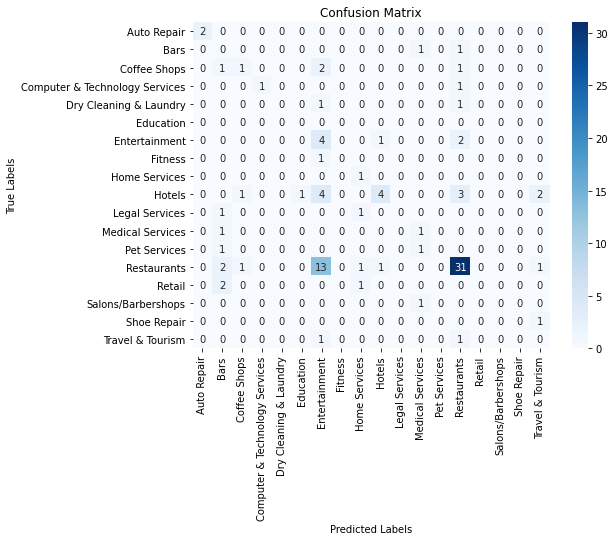

****************************DeBERTa model*******************************
Accuracy: 0.51
Classification Report:
                                  precision    recall  f1-score   support

                     Auto Repair       1.00      0.50      0.67         2
                            Bars       0.00      0.00      0.00         2
                    Coffee Shops       0.50      0.20      0.29         5
  Computer & Technology Services       1.00      0.50      0.67         2
          Dry Cleaning & Laundry       0.00      0.00      0.00         2
                       Education       0.00      0.00      0.00         0
                   Entertainment       0.27      0.43      0.33         7
                         Fitness       0.00      0.00      0.00         1
                   Home Services       0.00      0.00      0.00         1
                          Hotels       0.67      0.40      0.50        15
Landscaping & Gardening Services       0.00      0.00      0.00         0


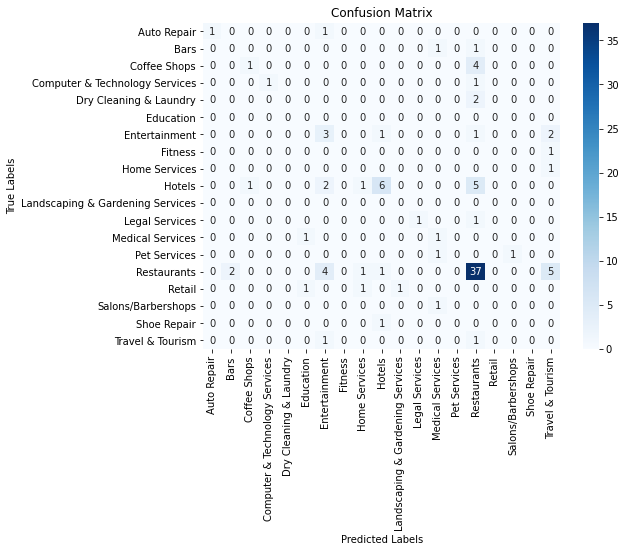

****************************CrossEncoder model*******************************
Accuracy: 0.5
Classification Report:
                                precision    recall  f1-score   support

                   Auto Repair       0.00      0.00      0.00         2
                          Bars       0.00      0.00      0.00         2
            Childcare Services       0.00      0.00      0.00         0
                  Coffee Shops       0.50      0.20      0.29         5
Computer & Technology Services       0.00      0.00      0.00         2
        Dry Cleaning & Laundry       0.00      0.00      0.00         2
                 Entertainment       0.17      0.57      0.27         7
            Financial Services       0.00      0.00      0.00         0
                       Fitness       0.00      0.00      0.00         1
                 Home Services       0.33      1.00      0.50         1
                        Hotels       0.67      0.27      0.38        15
                Lega

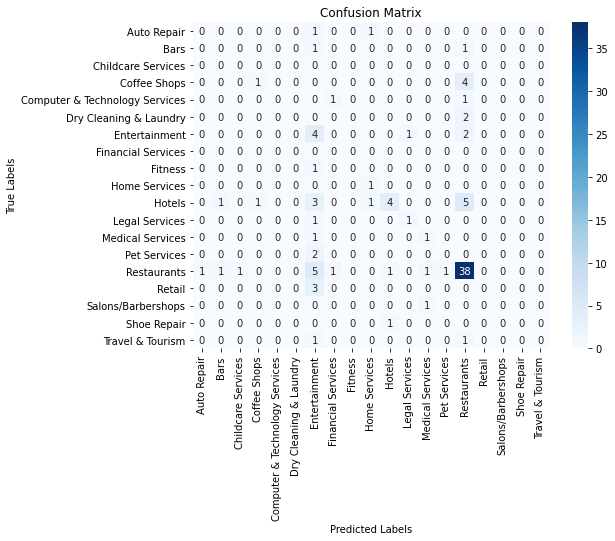

In [ ]:
for key in outcome.keys():
    print(f'****************************{key} model*******************************')
    ticklabels = sorted(set(manual_classification_result) | set(outcome[key]))
    evaluate(manual_classification_result, outcome[key], xticklabels=ticklabels, yticklabels=ticklabels)

## 4. Transfomer Performance Comparison

### For sentiment analysis
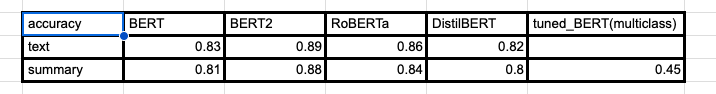

#### We can see the BERT2 model is performing best in both the text and the summary sentiment analysis task
* The BERT2 model was fine tuned on the review dataset. The dataset it's tuned on is quite similar to the yelp dataset. And that has contributed a lot to the high accuracy

#### The accuracy on the text are generally higher than the accuracy on the summary.
* One reason might be bart has a limited max_length for input text. And some texts might be too long for BART and got truncated.
* However, summary model is still doing quite a good job considering how small the difference is between the accuracies

#### The tuned_BERT model which was trained to do multi-class prediction didn't have a high accuracy on the dataset.
* Multiclass predication is always harder that binary class.

### For zero-shot classification
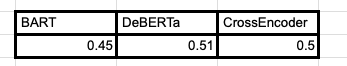

#### All three models are fined tuned on the MNLI dataset for zero-shot classification task.
* DeBERTa has the best performance. Cross-Encoder is not too bad either. The BART model is the worst among the three

### Things we learned from this assignment
* Hugging face is a very good resource for us to call pipelines and models to help us with NLP tasks
* When we choose the model to be used, we need to pay attention to:
  * The base model structure: BART, BERT, GPT, T5, Mistral etc.
  * The dataset that the models are fined tuned on: The more similar the dataset is to our dataset, the better the model might perform
  * The tasks the models are trained to perferm, such as text classification, summarization. We want to choose the task correctly
  * Each model has it's advantagesand disadvantages/limitations . We should look at 4-5 models when we try to do the task to see which model fits our need best